# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [32]:
import re
import torch

########## YOUR SOLUTION HERE ##########

class Encoder:
    def __init__(self, alphabet):
        self.char_to_idx = {char: idx for idx, char in enumerate(alphabet)} # map the character to the index
        self.idx_to_char = {idx: char for idx, char in enumerate(alphabet)} # map the index into the character

    def __call__(self, text):
        if isinstance(text, str):
            # Encode: Convert string to sequence of indices
            encoded = [self.char_to_idx.get(char, self.char_to_idx[' ']) for char in text]
            return torch.tensor(encoded)
        elif isinstance(text, torch.Tensor):
            # Decode: Convert sequence of indices back to string
            decoded = ''.join(self.idx_to_char[idx] for idx in text)
            return decoded
        else:
            raise TypeError("Wrong input: Input must be a string or a torch.Tensor")
        
    def get_char_to_index(self):
        return self.char_to_idx

    def get_index_to_char(self):
        return self.idx_to_char

## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [33]:
import torch
from torch.utils.data import Dataset

########## YOUR SOLUTION HERE ##########

class TextDataset(Dataset):
    def __init__(self, file_path, sequence_length, alphabet):
        with open(file_path, 'r', encoding='utf-8') as file:
            self.data = file.read()

        self.sequence_length = sequence_length
        self.total_sequences = len(self.data) // sequence_length
        self.alphabet = alphabet
        self.char_to_index = {char: index for index, char in enumerate(self.alphabet)}

    def __len__(self):
        # Return the total number of complete sequences
        return self.total_sequences

    def __getitem__(self, index):
        # Calculate the start and end index of the sequence
        start_idx = index * self.sequence_length
        end_idx = start_idx + self.sequence_length

        # Extract the sequence from the data
        sequence = self.data[start_idx:end_idx]

        # Convert the sequence to a list of integers (character ordinals)
        sequence = self.data[start_idx:end_idx]
        return torch.tensor([self.char_to_index.get(char, 0) for char in sequence], dtype=torch.long)



## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [34]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########

class NextCharLSTM(nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_dim):
        super(NextCharLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(alphabet_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Linear layer to map from hidden states to alphabet size
        self.linear = nn.Linear(hidden_dim, alphabet_size)

    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        # Pass through linear layer and return logits
        logits = self.linear(lstm_out)
        return logits

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [35]:
from torch.utils.data import DataLoader
import numpy as np

########## YOUR SOLUTION HERE ##########

def epoch(data_loader, model, optimizer=None):
    # Determine if we are in training mode
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Store losses for each mini-batch
    losses = []

    for batch in data_loader:
        input_seq = batch[:, :-1]  # All characters except the last
        target_seq = batch[:, 1:]  # All characters except the first

        # Forward pass
        logits = model(input_seq)

        logits = logits.view(-1, logits.shape[-1])
        target_seq = target_seq.reshape(-1)  # Changed from view to reshape

        # Calculate loss
        loss = criterion(logits, target_seq)

        if is_train:
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Store the loss value
        losses.append(loss.item())

    return np.array(losses)


## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

Epoch 1, Train Loss: 3.4840969153812953, Validation Loss: 3.1128954887390137
Epoch 2, Train Loss: 3.1814122131892613, Validation Loss: 2.9888827800750732
Epoch 3, Train Loss: 3.0059081213814873, Validation Loss: 2.8245651721954346
Epoch 4, Train Loss: 2.854191105706351, Validation Loss: 2.7415807247161865
Epoch 5, Train Loss: 2.715033783231463, Validation Loss: 2.639780282974243
Epoch 6, Train Loss: 2.582431854520525, Validation Loss: 2.5507125854492188
Epoch 7, Train Loss: 2.482733603886196, Validation Loss: 2.4682130813598633
Epoch 8, Train Loss: 2.3969517094748363, Validation Loss: 2.401714324951172
Epoch 9, Train Loss: 2.320293263026646, Validation Loss: 2.3369293212890625
Epoch 10, Train Loss: 2.241338430132185, Validation Loss: 2.264920234680176
Epoch 11, Train Loss: 2.1663638387407573, Validation Loss: 2.2109384536743164
Epoch 12, Train Loss: 2.0944618225097655, Validation Loss: 2.14558482170105
Epoch 13, Train Loss: 2.033702921867371, Validation Loss: 2.092714786529541
Epoch 14

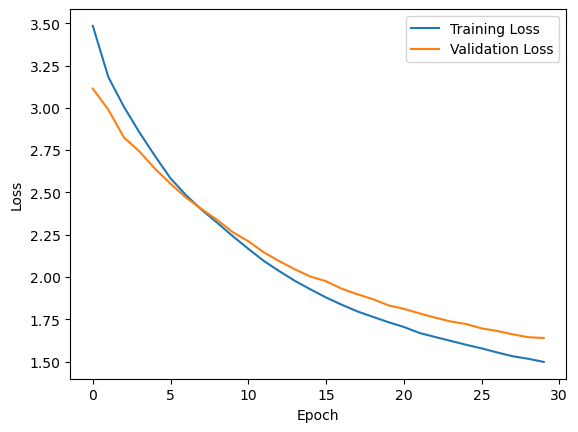

In [36]:
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 30

########## YOUR SOLUTION HERE ##########

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Create instances of TextDataset for training and validation

def extract_unique_characters(text):
    # Create a set to store unique characters
    unique_chars = set()

    # Iterate over each character in the text
    for char in text:
        unique_chars.add(char)

    # Convert the set to a sorted list and return
    return sorted(unique_chars)

def read_file(file_path):
    """Reads and returns the content of a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Read your training and validation data
train_text = read_file('trump_train.txt')
val_text = read_file('trump_val.txt')

# Extract unique characters from both datasets
unique_characters = extract_unique_characters(train_text + val_text)

# Define an alphabet. Modify this to match the characters in your dataset.
alphabet = ''.join(unique_characters)

model = NextCharLSTM(alphabet_size=len(alphabet), embedding_dim=embedding_dim, hidden_dim=hidden_dim)

# Create instances of the updated TextDataset for training and validation
train_dataset = TextDataset('trump_train.txt', sequence_length, alphabet)
valid_dataset = TextDataset('trump_val.txt', sequence_length, alphabet)

# Initialize DataLoader for the updated datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To keep track of the best model
best_val_loss = float('inf')
best_model = None

# To store losses for visualization
train_losses = []
valid_losses = []

# Rename the loop variable
for epoch_num in range(num_epochs):
    # Train for one epoch
    model.train()
    train_loss = epoch(train_loader, model, optimizer)
    train_losses.append(np.mean(train_loss))

    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = epoch(valid_loader, model)
        valid_losses.append(np.mean(val_loss))

    # Check if this is the best model so far
    if np.mean(val_loss) < best_val_loss:
        best_val_loss = np.mean(val_loss)
        best_model = model.state_dict()

    print(f"Epoch {epoch_num + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {valid_losses[-1]}")

# Save the best model
torch.save(best_model, 'best_model.pth')

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

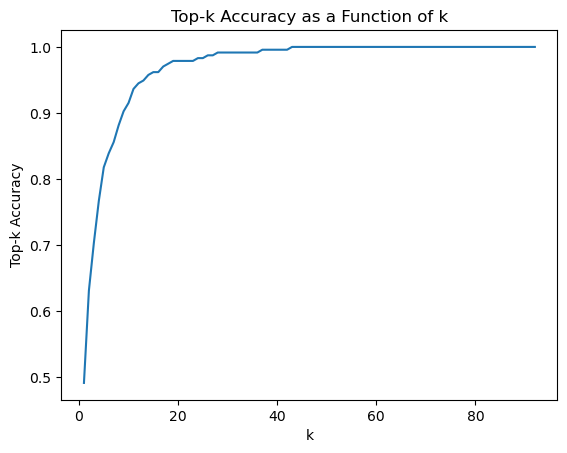

In [37]:
########## YOUR SOLUTION HERE ##########

import torch

def topk_accuracy(k_list, model, data_loader):
    model.eval()
    accuracies = {k: 0 for k in k_list}
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch[:, :-1], batch[:, -1]
            outputs = model(inputs)
            _, top_k_predictions = outputs.topk(max(k_list), dim=2, largest=True, sorted=True)

            for k in k_list:
                # correct = top_k_predictions[:, :k].eq(targets.unsqueeze(1).expand_as(top_k_predictions[:, :k]))
                # correct = top_k_predictions[:, :k].eq(targets.unsqueeze(1))
                # accuracies[k] += correct.sum().item()
                correct = top_k_predictions[:, -1, :k].eq(targets.view(-1, 1))
                accuracies[k] += correct.any(dim=1).sum().item()
            total_samples += targets.size(0)

    return {k: acc / total_samples for k, acc in accuracies.items()}

# Load the best model
best_model_path = 'best_model.pth'
best_model = NextCharLSTM(alphabet_size=len(alphabet), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
best_model.load_state_dict(torch.load(best_model_path))

# Evaluate top-k accuracy
k_values = list(range(1, len(alphabet) + 1))  # All possible values of k
accuracy_results = topk_accuracy(k_values, best_model, valid_loader)

# Plot top-k accuracy
import matplotlib.pyplot as plt

plt.plot(k_values, [accuracy_results[k] for k in k_values])
plt.xlabel('k')
plt.ylabel('Top-k Accuracy')
plt.title('Top-k Accuracy as a Function of k')
plt.show()

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size. 

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by 
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0 
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable 
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best. 

In [40]:
########## YOUR SOLUTION HERE ##########

import torch
import torch.nn.functional as F

def gumbel_max(logits, tau):
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
    return torch.argmax(logits / tau + gumbel_noise, dim=-1)

def generate_text(model, seed_text, length, tau, char_to_index, index_to_char):
    model.eval()
    generated_text = seed_text
    input_tensor = torch.tensor([char_to_index.get(char, 0) for char in seed_text], dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        for _ in range(length):
            logits = model(input_tensor)[-1, -1, :]
            next_char_index = gumbel_max(logits, tau)
            next_char = index_to_char[next_char_index.item()]
            generated_text += next_char

            next_char_tensor = torch.tensor([next_char_index], dtype=torch.long).unsqueeze(0)
            input_tensor = torch.cat((input_tensor[:, 1:], next_char_tensor), dim=1)

    return generated_text

# Load the best model
best_model_path = 'best_model.pth' 
model = NextCharLSTM(alphabet_size=len(unique_characters), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
model.load_state_dict(torch.load(best_model_path))

# Seed text and temperature values
seed_text = "Here comes the sun, and I say"
text_length = 200  # Length of the generated text
tau_values = [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]  # Different temperature values

encoder = Encoder(alphabet)
char_to_index = encoder.get_char_to_index()
index_to_char = encoder.get_index_to_char()

# Generate and print text for each tau value
for tau in tau_values:
    generated_text = generate_text(model, seed_text, text_length, tau, char_to_index, index_to_char)
    print(f"Generated text with tau={tau}:")
    print(generated_text)
    print("\n---\n")


Generated text with tau=0.1:
Here comes the sun, and I say they want to be a lot of the world and they want to do it. I want to be a lot of the world and I want to do it. I don’t know what happened and they want to be a lot of the world we have to do it. I d

---

Generated text with tau=0.3:
Here comes the sun, and I say " have a lot of the way in the way who we have to do the people and I want to be and they want to be a lot of the world we have to do it. We’re going to do it a lot of the world be a lot of the place

---

Generated text with tau=0.5:
Here comes the sun, and I say a good of ilang interest of the world be a look this country so what’s the way, the people and they’re will poll have because they could have a herico wele and they said, "We’re going to be wondentle

---

Generated text with tau=1.0:
Here comes the sun, and I say whowbh. Yeen all, hesure shat’s beln, hart a raegne of lot’s griened, I’m jo inon, think the Owa worles in thruows Thing uuo mo leteser Hallary. A

## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers. 

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set. 
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature? 

In [39]:
from heapq import heapify, heappop, heappush

def get_frequencies(text, alphabet):
    freqs = [0] * len(alphabet)
    char_to_index = {char: idx for idx, char in enumerate(alphabet)}
    
    for char in text:
        if char in char_to_index:
            freqs[char_to_index[char]] += 1

    total_chars = len(text)
    freqs = [freq / total_chars for freq in freqs]
    return freqs

def huffman_code(freqs):
    """This function turns a list of frequencies into a Huffman code. """
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [''] * len(freqs)
    
    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))
        
        for i in idx0:
            code[i] = '0' + code[i]
        
        for i in idx1:
            code[i] = '1' + code[i]
    
    return code

########## YOUR SOLUTION HERE ##########

import torch
import torch.nn.functional as F
from heapq import heapify, heappop, heappush

# Function to calculate average code length
def avg_code_length(text, code, char_to_index):
    total_length = sum(len(code[char_to_index[char]]) for char in text)
    return total_length / len(text)

# Function to calculate dynamic Huffman length using LSTM model
def dynamic_huffman_length(model, text, tau, char_to_index, index_to_char, sequence_length):
    model.eval()
    total_length = 0
    input_tensor = torch.tensor([char_to_index.get(char, 0) for char in text[:sequence_length]], dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        for i in range(len(text) - sequence_length):
            logits = model(input_tensor)[-1, -1, :]
            probs = F.softmax(logits / tau, dim=-1).tolist()
            dynamic_code = huffman_code(probs)
            next_char_index = char_to_index.get(text[i + sequence_length], 0)
            total_length += len(dynamic_code[next_char_index])

            # Update input tensor
            next_char_tensor = torch.tensor([next_char_index], dtype=torch.long).unsqueeze(0)
            input_tensor = torch.cat((input_tensor[:, 1:], next_char_tensor), dim=1)

    return total_length / (len(text) - sequence_length)

# Load the best model
model_path = 'best_model.pth'
model = NextCharLSTM(alphabet_size=len(unique_characters), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
model.load_state_dict(torch.load(model_path))

# Static Huffman coding based on training set frequencies
# Function 'get_frequencies' that returns a list of frequencies for each character in the alphabet
train_freqs = get_frequencies(train_text, alphabet=alphabet)
static_code = huffman_code(train_freqs)
static_avg_length = avg_code_length(val_text, static_code, char_to_index)

# Dynamic Huffman coding based on LSTM predictions
tau_values = [0.5, 1.0, 2.0]
for tau in tau_values:
    dynamic_avg_length = dynamic_huffman_length(model, val_text, tau, char_to_index, index_to_char, sequence_length)
    print(f"Dynamic Huffman Average Length with tau={tau}: {dynamic_avg_length}")

# Compare with static Huffman coding
print(f"Static Huffman Average Length: {static_avg_length}")


Dynamic Huffman Average Length with tau=0.5: 2.772671386780854
Dynamic Huffman Average Length with tau=1.0: 2.525713316657481
Dynamic Huffman Average Length with tau=2.0: 2.924789078729809
Static Huffman Average Length: 4.523156161607633
